In [1]:
import os
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
combined_dataframe = pd.read_csv('semi-processed_2.csv')

In [2]:
combined_dataframe['Type'] = combined_dataframe['Type'].replace('Individual', 'individual')
combined_dataframe['Secondary Material'] = combined_dataframe['Secondary Material'].fillna('None')
combined_dataframe['Composition'] = combined_dataframe['Composition'].fillna('None')

In [3]:
columns_to_drop = ['OP_Num', 'OTR_Num', 'PCO2_Num', 'WVP_Num', 'WVTR_Num']
combined_dataframe = combined_dataframe.drop(columns=[col for col in columns_to_drop if col in combined_dataframe.columns], errors='ignore')
# combined_dataframe.to_csv('semi-processed.csv')

In [4]:
value_counts = combined_dataframe[['OP_Unit', 'OTR_Unit', 'WVP_Unit', 'WVTR_Unit']].apply(pd.Series.value_counts)
print(value_counts)


             OP_Unit  OTR_Unit  WVP_Unit  WVTR_Unit
cm3/m2Pas        NaN       6.0       NaN        NaN
cm3/m2s          NaN       6.0       NaN        NaN
cm3cm/m2Pas     80.0       3.0       NaN        NaN
cm3cm/m2s        NaN       6.0       NaN        NaN
g/m2s            NaN       NaN       NaN       10.0
gm/m2Pas        11.0       NaN     134.0        NaN
gm/m2s           1.0       NaN       1.0        NaN
m3m/m2Pas        5.0       NaN       NaN        NaN
molm/m2Pas       5.0       NaN       2.0        NaN


In [5]:
# combined_dataframe.drop(columns='Doc')
# combined_dataframe = combined_dataframe[['Base Material', 'Type', 'Secondary Material',
#                                          'OP_Updated_Num', 'OP_Unit', 'OTR_Updated_Num', 'OTR_Unit',
#                                          'PCO2_Updated_Num', 'PCO2_Unit', 
#                                          'WVTR_Updated_Num', 'WVTR_Unit', 'WVP_Updated_Num', 'WVP_Unit', 
#                                          'thickness_Updated_Num', 'thickness_Unit', 
#                                          'temperature_Updated_Num', 'temperature_Unit', 
#                                          'RH_Updated_Num', 'RH_Unit', 
#                                          'Composition', 'Plasticizer']]
# combined_dataframe.to_csv('FE.csv')

In [6]:
# Apply the conversion where 'OP_Unit' is 'gm/m2Pas'
# Mass-to-volume
condition_o2g2cm = combined_dataframe['OP_Unit'] == 'gm/m2Pas'
combined_dataframe.loc[condition_o2g2cm, 'OP_Updated_Num'] *= 100/0.001429
combined_dataframe.loc[condition_o2g2cm, 'OP_Unit'] = 'cm3cm/m2Pas'


condition_o2m2cm = combined_dataframe['OP_Unit'] == 'm3m/m2Pas'
combined_dataframe.loc[condition_o2m2cm, 'OP_Updated_Num'] *= 100000000
combined_dataframe.loc[condition_o2m2cm, 'OP_Unit']  = 'cm3cm/m2Pas'


# o2 : 0.0014g/cm3, co2 : 0.001836 g/cm3
# Mass-to-volume
condition_o2m2cmg2cm = combined_dataframe['OP_Unit'] == 'gm/m2s'
combined_dataframe.loc[condition_o2m2cmg2cm, 'OP_Updated_Num'] *= 100/0.001429
combined_dataframe.loc[condition_o2m2cmg2cm,'OP_Unit'] = 'cm3cm/m2s'

# Mass-to-volume
condition_co2g2cm = combined_dataframe['PCO2_Unit'] == 'gm/m2Pas'
combined_dataframe.loc[condition_co2g2cm, 'OP_Updated_Num'] *= 100/0.001836
combined_dataframe.loc[condition_co2g2cm, 'PCO2_Unit'] = 'cm3cm/m2Pas'


condition_o2mol2cm = combined_dataframe['OP_Unit'] == 'molm/m2Pas'
combined_dataframe.loc[condition_o2mol2cm, 'OP_Updated_Num'] *= 116059.480952 
combined_dataframe.loc[condition_o2mol2cm, 'OP_Unit'] = 'cm3cm/m2Pas'

# 116059.480952 = 8.314*293.15*1000/21
condition_co2mol2cm = combined_dataframe['PCO2_Unit'] == 'molm/m2Pas'
combined_dataframe.loc[condition_co2mol2cm, 'PCO2_Updated_Num'] *= 116059.480952 
combined_dataframe.loc[condition_co2mol2cm, 'PCO2_Unit'] = 'cm3cm/m2Pas'

# molecular weight of water (18.0153 g/mol) converts
condition_wmol2g = combined_dataframe['WVP_Unit'] == 'molm/m2Pas'
combined_dataframe.loc[condition_wmol2g, 'WVP_Updated_Num'] *= 18.0153
combined_dataframe.loc[condition_wmol2g, 'WVP_Unit'] = 'gm/m2Pas'

#875448000000000
condition_o2 = combined_dataframe['OP_Unit'] == 'cm3cm/m2Pas'
combined_dataframe.loc[condition_o2, 'OP_Updated_Num'] *= 10000*86400*101325
combined_dataframe.loc[condition_o2, 'OP_Unit'] = 'cm3um/m2dayatm'

condition_wPa2kPa = combined_dataframe['WVP_Unit'] == 'gm/m2Pas'
combined_dataframe.loc[condition_wPa2kPa, 'WVP_Updated_Num'] *= 86400*1000000*1000
combined_dataframe.loc[condition_wPa2kPa, 'WVP_Unit'] = 'gum/m2daykPa'

In [7]:
combined_dataframe['thickness_Updated_Num'] = combined_dataframe['thickness_Updated_Num'].fillna(0.0001)
combined_dataframe['thickness_Unit'] = combined_dataframe['thickness_Unit'].fillna('m')

In [8]:
def calculate_otr(row):
    # under 1 atm and 
    if pd.notnull(row['OP_Updated_Num']) and row['OP_Unit'] == 'cm3um/m2dayatm':
        row['OTR_Updated_Num'] = row['OP_Updated_Num'] / (row['thickness_Updated_Num'] * 10**6) 
        row['OTR_Unit'] = 'cm3/m2day'

    if pd.notnull(row['OP_Updated_Num']) and row['OP_Unit'] == 'cm3cm/m2s':
        row['OTR_Updated_Num'] = row['OP_Updated_Num'] / row['thickness_Updated_Num'] * 864
        row['OTR_Unit'] = 'cm3/m2day'

    return row

def calculate_wvtr(row):
    if pd.notnull(row['WVP_Updated_Num']) and row['WVP_Unit'] == 'gum/m2daykPa':
        row['WVTR_Updated_Num'] = (row['WVP_Updated_Num'] * 101.325) / (row['thickness_Updated_Num'] * 10**6) 
        row['WVTR_Unit'] = 'g/m2day'
    return row
combined_dataframe = combined_dataframe.apply(calculate_otr, axis=1).apply(calculate_wvtr, axis=1)
# combined_dataframe = combined_dataframe.apply(calculate_wvtr, axis=1)

In [9]:
def convert_otr(row):
    if pd.notnull(row['OTR_Updated_Num']):
        if row['OTR_Unit'] == 'cm3/m2s':
            row['OTR_Updated_Num'] *= 86400
            row['OTR_Unit'] = 'cm3/m2day'
        elif row['OTR_Unit'] == 'cm3cm/m2s':
            row['OTR_Updated_Num'] = (row['OTR_Updated_Num'] * 864) / row['thickness_Updated_Num']
            row['OTR_Unit'] = 'cm3/m2day'
        elif row['OTR_Unit'] == 'cm3/m2Pas':
            row['OTR_Updated_Num'] = row['OTR_Updated_Num'] * 101325 * 86400
            row['OTR_Unit'] = 'cm3/m2day'
        elif row['OTR_Unit'] == 'cm3cm/m2Pas':
            row['OTR_Updated_Num'] = row['OTR_Updated_Num'] * 101325 * 864 / row['thickness_Updated_Num']
            row['OTR_Unit'] = 'cm3/m2day'
    return row

def convert_wvtr(row):
    if pd.notnull(row['WVTR_Updated_Num']):
        if row['WVTR_Unit'] == 'g/m2s':
            row['WVTR_Updated_Num'] *= 86400
            row['WVTR_Unit'] = 'g/m2day'
    return row
combined_dataframe = combined_dataframe.apply(convert_otr, axis=1).apply(convert_wvtr, axis=1)
# combined_dataframe.to_csv('after FE.csv')

In [10]:
combined_dataframe.columns

Index(['Unnamed: 0', 'Doc', 'OP_Updated_Num', 'OP_Unit', 'OTR_Updated_Num',
       'OTR_Unit', 'PCO2_Updated_Num', 'PCO2_Unit', 'WVTR_Updated_Num',
       'WVTR_Unit', 'WVP_Updated_Num', 'WVP_Unit', 'thickness_Updated_Num',
       'thickness_Unit', 'temperature_Updated_Num', 'temperature_Unit',
       'RH_Updated_Num', 'RH_Unit', 'Base Material', 'Type',
       'Secondary Material', 'Composition', 'Plasticizer'],
      dtype='object')

In [11]:
columns = ['OP_Updated_Num', 'OTR_Updated_Num', 'PCO2_Updated_Num', 'WVTR_Updated_Num', 'WVP_Updated_Num']

# Calculate summary statistics
summary_stats = combined_dataframe[columns].describe().transpose()

# Add median to the summary statistics
# Display the summary statistics
print(summary_stats.round(3))

                  count          mean           std    min       25%  \
OP_Updated_Num    102.0  3.095102e+19  3.117824e+20  0.000   436.266   
OTR_Updated_Num   123.0  2.566670e+17  2.839233e+18  0.000    11.578   
PCO2_Updated_Num   29.0  0.000000e+00  3.000000e-03  0.000     0.000   
WVTR_Updated_Num  143.0  1.231641e+08  1.331648e+09  0.257  1038.401   
WVP_Updated_Num   137.0  1.268580e+08  1.342661e+09  0.000  1131.840   

                        50%         75%           max  
OP_Updated_Num     2644.110  680038.989  3.148917e+21  
OTR_Updated_Num     249.533    5936.851  3.148917e+19  
PCO2_Updated_Num      0.000       0.000  1.400000e-02  
WVTR_Updated_Num  19251.750  107901.772  1.590794e+10  
WVP_Updated_Num    6324.480   57591.311  1.569992e+10  


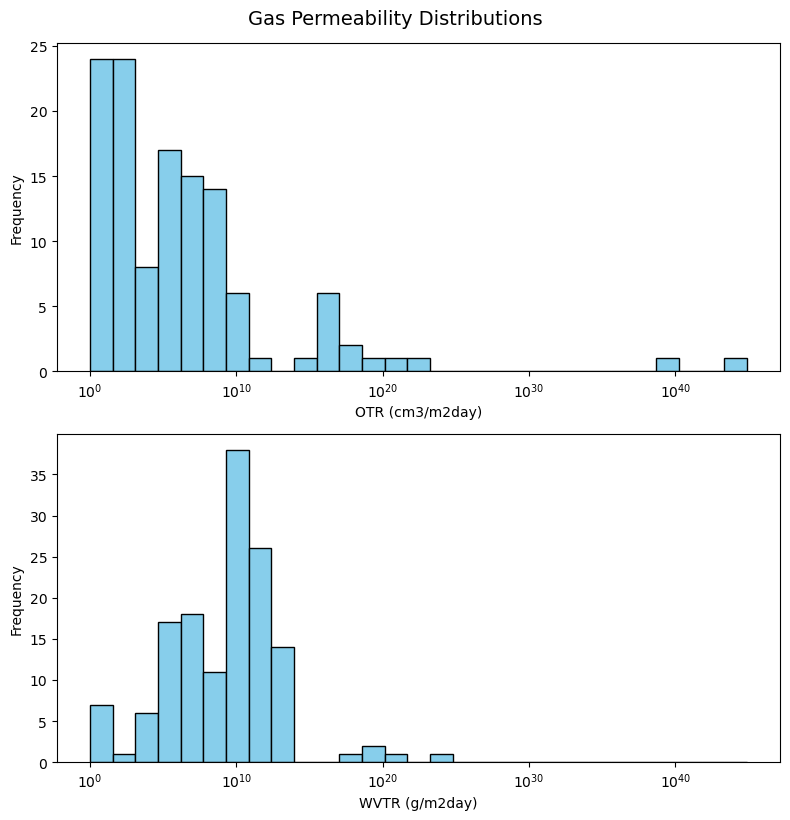

In [12]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example combined_dataframe setup (replace this with your actual data)
# combined_dataframe = pd.DataFrame({...})

# List of columns to visualize
coll = [ 'OTR', 'WVTR']
text = '_Updated_Num'
u = '_Unit'
columns = [c + text for c in coll]

# Create subplots
fig, axes = plt.subplots(nrows=len(coll), ncols=1, figsize=(8, len(columns) * 4))

all_data = pd.concat([combined_dataframe[col].dropna() for col in columns])
log_all_data = np.log1p(all_data)  # Log-transform combined data for bin calculation
bins = np.linspace(log_all_data.min(), log_all_data.max(), 30)

# Formatter to convert log scale to powers of 10
def log_to_power_of_10(x, pos):
    return f"$10^{{{int(x)}}}$"

formatter = FuncFormatter(log_to_power_of_10)

for i, col in enumerate(columns):
    # Get the corresponding unit column
    unit_column = col.replace(text, u)

    # Find the most common unit
    if unit_column in combined_dataframe:
        most_common_unit = combined_dataframe[unit_column].value_counts().idxmax()
    else:
        most_common_unit = "unknown"  # Fallback if the unit column doesn't exist

    # Drop NaN values and apply log transformation (add 1 to avoid log(0))
    data = combined_dataframe[col].dropna()
    log_data = np.log1p(data)  # log1p handles log(1 + x)

    # Plot histogram
    axes[i].hist(log_data, bins=bins, color='skyblue', edgecolor='black')
    axes[i].set_xlabel(f"{col.split('_')[0]} ({most_common_unit})")  # Set x-label with unit
    axes[i].set_ylabel('Frequency')

    # Apply custom formatter to x-axis
    axes[i].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.suptitle('Gas Permeability Distributions', y=1.02, fontsize=14)
plt.show()


In [13]:
# Create new columns for OP temperature
combined_dataframe['OTR_temperature_Num'] = combined_dataframe.apply(
    lambda row: row['temperature_Updated_Num'] if pd.notnull(row['OTR_Updated_Num']) else None, axis=1)
combined_dataframe['OTR_temperature_Unit'] = combined_dataframe.apply(
    lambda row: row['temperature_Unit'] if pd.notnull(row['OTR_Updated_Num']) else None, axis=1)
combined_dataframe['OTR_RH_Num'] = combined_dataframe.apply(
    lambda row: row['RH_Updated_Num'] if pd.notnull(row['OTR_Updated_Num']) else None, axis=1)
combined_dataframe['OTR_RH_Unit'] = combined_dataframe.apply(
    lambda row: row['RH_Unit'] if pd.notnull(row['OTR_Updated_Num']) else None, axis=1)


# Create new columns for WVP temperature
combined_dataframe['WVTR_temperature_Num'] = combined_dataframe.apply(
    lambda row: row['temperature_Updated_Num'] if pd.notnull(row['WVTR_Updated_Num']) else None, axis=1)
combined_dataframe['WVTR_temperature_Unit'] = combined_dataframe.apply(
    lambda row: row['temperature_Unit'] if pd.notnull(row['WVTR_Updated_Num']) else None, axis=1)
combined_dataframe['WVTR_RH_Num'] = combined_dataframe.apply(
    lambda row: row['RH_Updated_Num'] if pd.notnull(row['WVTR_Updated_Num']) else None, axis=1)
combined_dataframe['WVTR_RH_Unit'] = combined_dataframe.apply(
    lambda row: row['RH_Unit'] if pd.notnull(row['WVTR_Updated_Num']) else None, axis=1)

combined_dataframe['Type'] = combined_dataframe['Type'].replace('Individual', 'individual')

In [14]:
conventional_materials = ['polypropylene', 'polyethylene', 'polyvinyl chloride', 'LDPE', 'HDPE', 'poly(n-butyl methacrylate)', 'polyethylene terephthalate', 'EVOH', 'polysulfone']

# Create a new column 'Material' based on the condition
combined_dataframe['Material'] = combined_dataframe['Base Material'].apply(lambda x: 'conventional' if x in conventional_materials else 'sustainable')


In [15]:
col = ['Base Material', 'Type', 'Secondary Material','Material']

otr = combined_dataframe.filter(regex='^OTR', axis=1)
op = combined_dataframe.filter(regex='^OP', axis=1)
wvp = combined_dataframe.filter(regex='^WVP', axis=1)
wvtr = combined_dataframe.filter(regex='^WVTR', axis=1)

op[col] = combined_dataframe[col]
otr[col] = combined_dataframe[col]
wvp[col] = combined_dataframe[col]
wvtr[col] = combined_dataframe[col]


/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/1357264389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op[col] = combined_dataframe[col]
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/1357264389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op[col] = combined_dataframe[col]
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/1357264389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [16]:
fop = op[op['OP_Updated_Num'].notnull()]
fotr = otr[otr['OTR_Updated_Num'].notnull()]
fwvp = wvp[wvp['WVP_Updated_Num'].notnull()]
fwvtr = wvtr[wvtr['WVTR_Updated_Num'].notnull()]

In [17]:
fotr['OTR_temperature_Num'] = fotr['OTR_temperature_Num'].fillna(23.0)
fotr['OTR_RH_Num'] = fotr['OTR_RH_Num'].fillna(50.0)
fwvtr['WVTR_temperature_Num'] = fwvtr['WVTR_temperature_Num'].fillna(25.0)
fwvtr['WVTR_RH_Num'] = fwvtr['WVTR_RH_Num'].fillna(50.0)

/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/4199108202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fotr['OTR_temperature_Num'] = fotr['OTR_temperature_Num'].fillna(23.0)
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/4199108202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fotr['OTR_RH_Num'] = fotr['OTR_RH_Num'].fillna(50.0)
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/4199108202.py:3: SettingWithCopyWarning: 
A value is trying to be s

In [18]:
print('fotr before', len(fotr))
fotr = fotr[(fotr['OTR_temperature_Num'] == 23.0) & (fotr['OTR_RH_Num'] == 50.0)]
print('fotr after', len(fotr))
print('fwvtr after', len(fwvtr))
fwvtr = fwvtr[(fwvtr['WVTR_temperature_Num'] == 25.0) & (fwvtr['WVTR_RH_Num'] == 50.0)]
print('fwvtr after', len(fwvtr))

fotr before 123
fotr after 51
fwvtr after 143
fwvtr after 72


In [19]:
combine_df_tr = pd.merge(fotr, fwvtr, on=col, how='outer')
dtr = combine_df_tr[['WVTR_Updated_Num','OTR_Updated_Num'] + col]
fotr['OTR_Updated_Num'].describe()

count    5.100000e+01
mean     3.105970e+07
std      1.572773e+08
min      1.013244e-01
25%      3.030175e+00
50%      1.223001e+01
75%      5.116912e+02
max      1.013244e+09
Name: OTR_Updated_Num, dtype: float64

In [20]:
fwvtr['WVTR_Updated_Num'].describe()

count        72.000000
mean     101134.975836
std      126553.201389
min          19.259856
25%        1920.514050
50%       38250.962338
75%      200608.909200
max      580509.568800
Name: WVTR_Updated_Num, dtype: float64

In [21]:
# Load datasets
data = fotr  # Replace with your dataset filename
fotr['OTR_temperature_Num'] = fotr['OTR_temperature_Num'].fillna(23.0)
fotr['OTR_RH_Num'] = fotr['OTR_RH_Num'].fillna(50.0)

In [22]:
fotr['OTR_temperature_Num'].describe()

count    51.0
mean     23.0
std       0.0
min      23.0
25%      23.0
50%      23.0
75%      23.0
max      23.0
Name: OTR_temperature_Num, dtype: float64

/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/3840036103.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fwvtr_data = fwvtr[col].dropna() if col in fwvtr else pd.Series()
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/3840036103.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fotr_data = fotr[col].dropna() if col in fotr else pd.Series()


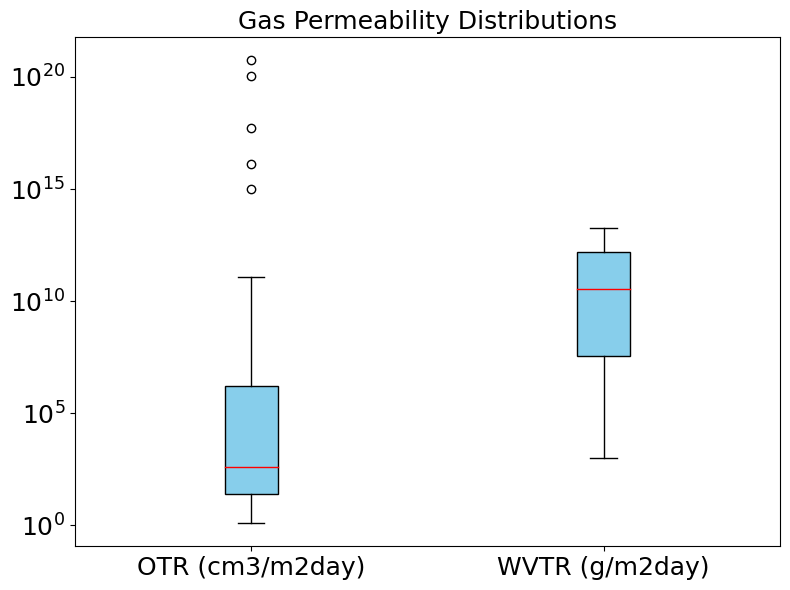

In [23]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# List of columns to visualize
coll = ['OTR', 'WVTR']
text = '_Updated_Num'
u = '_Unit'
columns = [c + text for c in coll]

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Formatter to convert log scale to powers of 10
def log_to_power_of_10(x, pos):
    return f"$10^{{{int(x)}}}$"

formatter = FuncFormatter(log_to_power_of_10)

# Data preparation for OTR and WVTR
combined_data = []
labels = []
for col in columns:
    # Initialize data for plotting (from both fotr and fwvtr)
    fotr_data = fotr[col].dropna() if col in fotr else pd.Series()
    fwvtr_data = fwvtr[col].dropna() if col in fwvtr else pd.Series()

    # Find the most common unit for each column
    unit_column = col.replace(text, u)
    most_common_unit = "unknown"
    if unit_column in fotr:
        most_common_unit = fotr[unit_column].value_counts().idxmax()
    elif unit_column in fwvtr:
        most_common_unit = fwvtr[unit_column].value_counts().idxmax()

    # Combine fotr and fwvtr data
    combined_col_data = pd.concat([fotr_data, fwvtr_data])

    # Apply log transformation
    log_combined_col_data = np.log1p(combined_col_data)

    # Append data and labels for boxplot
    combined_data.append(log_combined_col_data)
    labels.append(f"{col.split('_')[0]} ({most_common_unit})")

# Plot a single boxplot for all data
ax.boxplot(combined_data, labels=labels, patch_artist=True,
           boxprops=dict(facecolor='skyblue', color='black'),
           medianprops=dict(color='red')),

ax.tick_params(axis='both', which='major', labelsize=18)

# Set labels and formatting
# ax.set_ylabel("Log-Transformed Values")
ax.yaxis.set_major_formatter(formatter)
plt.title('Gas Permeability Distributions', fontsize=18)
plt.tight_layout()
plt.show()


In [24]:
# ## transmission rate
dtr['log_WVTR_Updated_Num'] = np.log10(dtr['WVTR_Updated_Num'])
dtr['log_OTR_Updated_Num'] = np.log10(dtr['OTR_Updated_Num'])

fig = px.scatter(
        dtr,
        x='log_WVTR_Updated_Num',
        y='log_OTR_Updated_Num',
        color='Type',  # Color by 'Base Material'
        symbol='Material',
        symbol_sequence= ['circle', 'circle-open'],
        hover_data=['Base Material', 'Type', 'Secondary Material'],  # Include additional info in hover
        title='Log-scale scatterplot of OTR vs WVTR',
        labels={
            'log_OP_Updated_Num': 'OTR Updated Num',
            'log_WVTr_Updated_Num': 'WVTR Updated Num'
        }
    )
    
    # Show the plot
fig.show()
plotly.offline.plot(fig, filename='Scatterplot of OTR vs WVTR.html', auto_open=False)

/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/1347698943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtr['log_WVTR_Updated_Num'] = np.log10(dtr['WVTR_Updated_Num'])
/var/folders/qs/8x1gpygd3nl0wldh8bphz0f80000gn/T/ipykernel_44813/1347698943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtr['log_OTR_Updated_Num'] = np.log10(dtr['OTR_Updated_Num'])


'Scatterplot of OTR vs WVTR.html'

In [25]:
# Define tick values and labels for power-of-10 formatting
tick_vals_x = np.arange(
    int(np.floor(dtr['log_WVTR_Updated_Num'].min())), 
    int(np.ceil(dtr['log_WVTR_Updated_Num'].max())) + 1
)
tick_text_x = [f"10^{int(i)}" for i in tick_vals_x]

tick_vals_y = np.arange(
    int(np.floor(dtr['log_OTR_Updated_Num'].min())), 
    int(np.ceil(dtr['log_OTR_Updated_Num'].max())) + 1
)
tick_text_y = [f"10^{int(i)}" for i in tick_vals_y]

c = 'Base Material'
# Create the scatter plot
fig = px.scatter(
    dtr,
    x='log_WVTR_Updated_Num',
    y='log_OTR_Updated_Num',
    color= c,  # Color by 'Base Material'
    symbol='Material',
    symbol_sequence= ['circle', 'circle-open'], 
    hover_data=['Base Material', 'Type', 'Secondary Material'],  # Include additional info in hover
    title='Scatterplot of OTR vs WVTR by ' + c + ' under 1atm, 100um', 
    labels={
        'log_WVTR_Updated_Num': 'WVTR Updated Num',
        'log_OTR_Updated_Num': 'OTR Updated Num'
    }
)

# Update axis labels and ticks for power-of-10 display
fig.update_layout(
    xaxis=dict(
        title="WVTR Num (g/m2day)",
        tickvals=tick_vals_x,
        ticktext=tick_text_x,
        # type='linear'  # Keeps the axis linear while displaying log ticks
    ),
    yaxis=dict(
        title="OTR Num (cm3/m2day)",
        tickvals=tick_vals_y,
        ticktext=tick_text_y,
        # type='linear'  # Keeps the axis linear while displaying log ticks
    ),
    template="plotly_white"
)

# Show the plot
fig.show()
plotly.offline.plot(fig, filename='Scatterplot of OTR vs WVTR (power 10).html', auto_open=False)

'Scatterplot of OTR vs WVTR (power 10).html'

In [26]:
base = dtr['Base Material'].unique()
non_sustainable_materials = ['LDPE', 'HDPE', 'polypropylene', 'polyethylene', 'PET', 'EVOH', 'polyvinyl chloride', 'amylose','polypropylene films']  # Example list
sustainable_materials = set(base) - set(non_sustainable_materials)


## Models Fitting

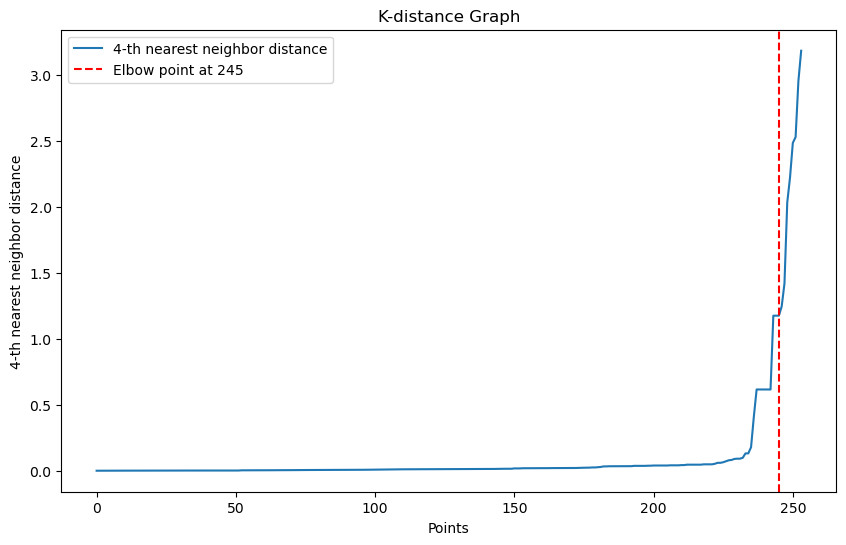

Epsilon value detected at: 1.1765824040255133


In [27]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
features = dtr[['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']].dropna().values  # Drop rows with NaN

def plot_k_distance_graph(X, k):
    # Fit NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    
    # Sort distances for k-th neighbor
    distances = np.sort(distances[:, k-1])

    # Detect the elbow point
    knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    elbow_point = knee_locator.knee
    epsilon = distances[elbow_point] if elbow_point is not None else None

    # Plot the K-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances, label=f'{k}-th nearest neighbor distance')
    if elbow_point is not None:
        plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow point at {elbow_point}')
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.legend()
    plt.show()

    return epsilon

# Plot k-distance graph with elbow detection
epsilon = plot_k_distance_graph(features, k=4)
print(f"Epsilon value detected at: {epsilon}")



/Users/windy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/windy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/windy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/windy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/windy/opt/anaconda3/lib/python3.8/site-packages/sklearn/clust

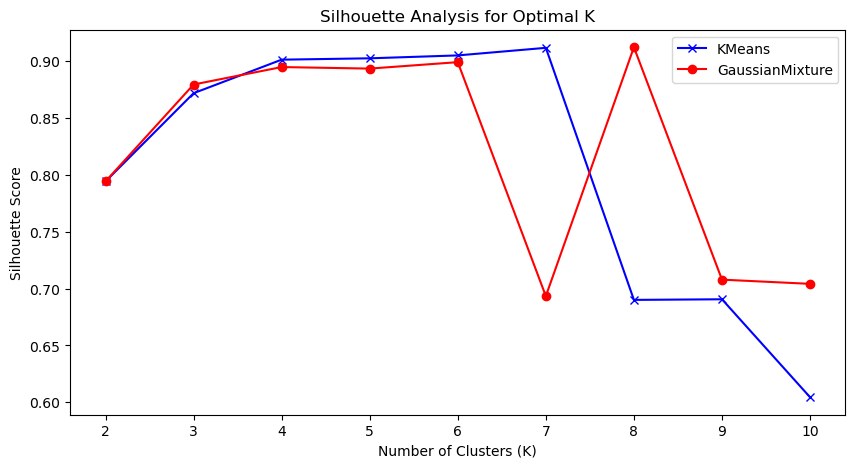

In [28]:
# check which clusters is the optimium clusters 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Prepare features for clustering
features = dtr[['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']].dropna().values  # Drop rows with NaN
# features = features_encoded

# Check for valid data
if features.shape[0] == 0:
    raise ValueError("No valid data points available for clustering after removing NaNs.")


from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avg_k = []
silhouette_avg_g = []

for num_clusters in range_n_clusters:
    # Initialize KMeans and GaussianMixture
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    gmm = GaussianMixture(n_components=num_clusters, random_state=42)
    
    # Fit models
    kmeans.fit(features)
    cluster_labels_k = kmeans.labels_
    cluster_labels_g = gmm.fit_predict(features)  # Use predict for GaussianMixture
    
    # Calculate silhouette scores
    silhouette_avg_k.append(silhouette_score(features, cluster_labels_k))
    silhouette_avg_g.append(silhouette_score(features, cluster_labels_g))

# Plot silhouette scores for KMeans
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_avg_k, 'bx-', label='KMeans')
plt.plot(range_n_clusters, silhouette_avg_g, 'ro-', label='GaussianMixture')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.legend()
plt.show()

### Kmeans

In [29]:
features = dtr[['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']].dropna().values  # Drop rows with NaN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define whether to use normalization
use_normalization = True
# Normalize data if required
if use_normalization:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
else:
    normalized_features = features


# Check for valid data
if features.shape[0] == 0:
    raise ValueError("No valid data points available for clustering after removing NaNs.")

# Set the number of clusters
k = 6

# Apply KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(normalized_features)

# Add cluster labels to the original DataFrame
d_clean = dtr.dropna(subset=['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']).copy()
d_clean['Cluster'] = labels

# Map clusters to Base Material
cluster_base_material_map = (
    d_clean.groupby('Cluster')['Base Material']
    .apply(lambda x: x.mode()[0] if not x.empty else f"Cluster {x.name}")
    .to_dict()
)

# Assign a color palette for clusters
color_palette = px.colors.qualitative.Plotly  # Get Plotly color palette
cluster_colors = {cluster: color_palette[i % len(color_palette)] for i, cluster in enumerate(cluster_base_material_map.keys())}

# Initialize a Plotly figure
fig = go.Figure()

# Add scatter plot for each cluster
for cluster_label in np.unique(labels):
    cluster_data = d_clean[d_clean['Cluster'] == cluster_label]
    cluster_size = len(cluster_data) 
    # cluster_name = f"Cluster {cluster_label} ({cluster_size} points) - {cluster_base_material_map[cluster_label]}"
    cluster_name = f"Cluster {cluster_label} ({cluster_size} points)"
    cluster_color = cluster_colors[cluster_label]
    
    marker_colors = [
        f"rgba({int(int(cluster_color.lstrip('#')[0:2], 16) * 0.7)},"
        f"{int(int(cluster_color.lstrip('#')[2:4], 16) * 0.7)},"
        f"{int(int(cluster_color.lstrip('#')[4:6], 16) * 0.7)}, 1)"
        if is_sustainable else cluster_color
        for is_sustainable in cluster_data['Material'].str.lower().eq('sustainable')
    ]

    # Adjust marker shape for conventional materials
    marker_symbols = [
        'triangle-up' if is_conventional else 'circle'
        for is_conventional in cluster_data['Material'].str.lower().eq('conventional')
    ]

    fig.add_trace(go.Scatter(
        x=cluster_data['log_WVTR_Updated_Num'],
        y=cluster_data['log_OTR_Updated_Num'],
        mode='markers',
        name=cluster_name,  # Legend entry with cluster number and base material
        marker=dict(size=10, color=marker_colors, symbol=marker_symbols),
        hovertemplate=(
            "Base Material: %{text}<br>"
            "Type: %{customdata[0]}<br>"
            "Secondary Material: %{customdata[1]}<br>"
            "Material:%{customdata[2]}<br>"
            "log(WVTR): %{x}<br>"
            "log(OTR): %{y}"
        ),
        text=cluster_data['Base Material'],
        customdata=cluster_data[['Type', 'Secondary Material','Material']].values
    ))

    # Calculate cluster boundary (bounding box)
    x_min = cluster_data['log_WVTR_Updated_Num'].min()
    x_max = cluster_data['log_WVTR_Updated_Num'].max()
    y_min = cluster_data['log_OTR_Updated_Num'].min()
    y_max = cluster_data['log_OTR_Updated_Num'].max()

    # Convert hex color to rgba for transparency
    if cluster_color.startswith("#"):
        r, g, b = tuple(int(cluster_color.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))
        fill_color = f"rgba({r}, {g}, {b}, 0.1)"
    else:
        fill_color = cluster_color  # Fallback if color is not in hex format

    # Add a rectangle for the cluster boundary
    fig.add_shape(
        type="rect",
        x0=x_min, x1=x_max,
        y0=y_min, y1=y_max,
        line=dict(color=cluster_color, width=3),
        fillcolor=fill_color
    )
file_suffix = "normalized" if use_normalization else "unnormalized"
fig.update_layout(
    title="Kmeans Model Clustering with Cluster Boundaries_log",
    xaxis_title="WVTR (g/m2day)",
    yaxis_title="OTR (cm3/m2day)",
    template="plotly_white"
)
plotly.offline.plot(fig, filename=f'Kmeans_cluster_OP_vs_WVP_log_{file_suffix}.html', auto_open=False)

tick_vals_x = np.linspace(int(d_clean['log_WVTR_Updated_Num'].min()-1), int(d_clean['log_WVTR_Updated_Num'].max()+1), int(d_clean['log_WVTR_Updated_Num'].max()-d_clean['log_WVTR_Updated_Num'].min()+2))
tick_text_x = [f"10<sup>{int(val)}</sup>" for val in tick_vals_x]

tick_vals_y = np.linspace(int(d_clean['log_OTR_Updated_Num'].min()-1), int(d_clean['log_OTR_Updated_Num'].max()+1), int(d_clean['log_OTR_Updated_Num'].max()-d_clean['log_OTR_Updated_Num'].min()+2))
tick_text_y = [f"10<sup>{int(val)}</sup>" for val in tick_vals_y]




fig.update_layout(
    title="Kmeans Model Clustering with Cluster Boundaries",
    xaxis_title="WVTR (g/m2day)",
    yaxis_title="OTR (cm3/m2day)",
    template="plotly_white"
)    
fig.update_layout(
    xaxis=dict(
        title="WVTR (g/m2day)",
        tickvals=tick_vals_x,
        ticktext=tick_text_x,
        type='linear',  # Keeps the axis linear while displaying log ticks
        tickfont=dict(size=16),
    ),
    yaxis=dict(
        title="OTR (cm3/m2day)",
        tickvals=tick_vals_y,
        ticktext=tick_text_y,
        type='linear',  # Keeps the axis linear while displaying log ticks
        tickfont=dict(size=16),
    ),
    template="plotly_white"
# Show the updated plot
)
fig.show()
plotly.offline.plot(fig, filename=f'Kmeans_cluster_OP_vs_WVP_{file_suffix}.html', auto_open=False)

/Users/windy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



'Kmeans_cluster_OP_vs_WVP_normalized.html'

In [30]:
cluster_2_data = d_clean[d_clean['Cluster'] == 2]

# Display relevant information
columns_of_interest = ['Base Material', 'Type', 'Secondary Material']
cluster_2_info = cluster_2_data[columns_of_interest]

# Print the details
print(cluster_2_info)

      Base Material        Type Secondary Material
57             LDPE  individual               None
58             LDPE  individual               None
59             HDPE  individual               None
68  polylactic acid  individual               None
69  polylactic acid  individual               None
70  polylactic acid  individual               None


### Gaussian Mixture Matrix

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Define whether to use normalization
use_normalization = False

# Select features and drop rows with NaN
features = dtr[['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']].dropna().values

# Normalize data if required
if use_normalization:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
else:
    normalized_features = features
    
# Fit the Gaussian Mixture Model
n_components = 6 # Set the number of clusters
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(features)

# Predict cluster labels
labels = gmm.predict(normalized_features)

# Add cluster labels to the original DataFrame
d_clean = dtr.dropna(subset=['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']).copy()
d_clean['Cluster'] = labels

# Map clusters to Base Material
cluster_base_material_map = (
    d_clean.groupby('Cluster')['Base Material']
    .apply(lambda x: x.mode()[0] if not x.empty else f"Cluster {x.name}")
    .to_dict()
)
# Assign a color palette for clusters
color_palette = px.colors.qualitative.Plotly  # Get Plotly color palette
cluster_colors = {cluster: color_palette[i % len(color_palette)] for i, cluster in enumerate(cluster_base_material_map.keys())}

# Initialize a Plotly figure
fig = go.Figure()

for cluster_label in np.unique(labels):
    cluster_data = d_clean[d_clean['Cluster'] == cluster_label]
    cluster_size = len(cluster_data) 
    # cluster_name = f"Cluster {cluster_label} ({cluster_size} points) - {cluster_base_material_map[cluster_label]}"
    cluster_name = f"Cluster {cluster_label} ({cluster_size} points)"
    cluster_color = cluster_colors[cluster_label]
    
    marker_colors = [
        f"rgba({int(int(cluster_color.lstrip('#')[0:2], 16) * 0.7)},"
        f"{int(int(cluster_color.lstrip('#')[2:4], 16) * 0.7)},"
        f"{int(int(cluster_color.lstrip('#')[4:6], 16) * 0.7)}, 1)"
        if is_sustainable else cluster_color
        for is_sustainable in cluster_data['Material'].str.lower().eq('sustainable')
    ]

    # Adjust marker shape for conventional materials
    marker_symbols = [
        'triangle-up' if is_conventional else 'circle'
        for is_conventional in cluster_data['Material'].str.lower().eq('conventional')
    ]

    fig.add_trace(go.Scatter(
        x=cluster_data['log_WVTR_Updated_Num'],  # X-axis: log(WVP)
        y=cluster_data['log_OTR_Updated_Num'],  # Y-axis: log(OP)
        mode='markers',
        name=cluster_name,
        # symbol = 'Material',
        marker=dict(size=10, color=marker_colors, symbol=marker_symbols),
        hovertemplate=(
            "Base Material: %{text}<br>"
            "Type: %{customdata[0]}<br>"
            "Secondary Material: %{customdata[1]}<br>"
            "log(WVTR): %{x}<br>"
            "log(OTR): %{y}"
        ),
        text=cluster_data['Base Material'],
        customdata=cluster_data[['Type', 'Secondary Material']].values
    ))

    # Calculate cluster boundary (bounding box)
    x_min = cluster_data['log_WVTR_Updated_Num'].min()
    x_max = cluster_data['log_WVTR_Updated_Num'].max()
    y_min = cluster_data['log_OTR_Updated_Num'].min()
    y_max = cluster_data['log_OTR_Updated_Num'].max()

    # Convert hex color to rgba for transparency
    if cluster_color.startswith("#"):
        r, g, b = tuple(int(cluster_color.lstrip("#")[i:i+2], 16) for i in (0, 2, 4))
        fill_color = f"rgba({r}, {g}, {b}, 0.1)"
    else:
        fill_color = cluster_color  # Fallback if color is not in hex format

    # Add a rectangle for the cluster boundary
    fig.add_shape(
        type="rect",
        x0=x_min, x1=x_max,
        y0=y_min, y1=y_max,
        line=dict(color=cluster_color, width=2),
        fillcolor=fill_color
    )
plotly.offline.plot(fig, filename=f'GMM_cluster_OP_vs_WVP_log_{file_suffix}.html', auto_open=False)


tick_vals_x = np.linspace(d_clean['log_WVTR_Updated_Num'].min()-1, d_clean['log_WVTR_Updated_Num'].max()+1, 10)
tick_text_x = [f"10<sup>{int(val)}</sup>" for val in tick_vals_x]

tick_vals_y = np.linspace(d_clean['log_OTR_Updated_Num'].min()-1, d_clean['log_OTR_Updated_Num'].max()+1, 10)
tick_text_y = [f"10<sup>{int(val)}</sup>" for val in tick_vals_y]


# Export the plot
file_suffix = "normalized" if use_normalization else "unnormalized"

# Update layout
fig.update_layout(
    title=f"GMM Clustering with Cluster Boundaries_{file_suffix}",
    xaxis_title="log WVTR",
    yaxis_title="log OTR",
    template="plotly_white"
)

# Update axis labels and ticks for power-of-10 display
fig.update_layout(
    xaxis=dict(
        title="WVTR (g/m2day)",
        tickvals=tick_vals_x,
        ticktext=tick_text_x,
        tickfont=dict(size=16),
        type='linear'  # Keeps the axis linear while displaying log ticks
    ),
    yaxis=dict(
        title="OTR (cm3/m2day)",
        tickvals=tick_vals_y,
        ticktext=tick_text_y,
        tickfont=dict(size=16),
        type='linear'  # Keeps the axis linear while displaying log ticks
    ),
    # template="plotly_white"
)

fig.show()

plotly.offline.plot(fig, filename=f'GMM_cluster_OP_vs_WVP_{file_suffix}.html', auto_open=False)

'GMM_cluster_OP_vs_WVP_unnormalized.html'

### DBSCAN

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Define whether to use normalization
use_normalization = True

# Select features and drop rows with NaN
features = dtr[['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']].dropna().values


# Normalize data if required
if use_normalization:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
else:
    normalized_features = features
   
# Check for valid data
if features.shape[0] == 0:
    raise ValueError("No valid data points available for clustering after removing NaNs.")

# ----------------------------------------------------
# 3. Apply DBSCAN clustering
# ----------------------------------------------------
eps = 1.17
min_samples = 4
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(normalized_features)

# ----------------------------------------------------
# 4. Add cluster labels to the original DataFrame
# ----------------------------------------------------
# We assume 'd_clean' aligns with 'features' row order
d_clean = dtr.dropna(subset=['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']).copy()
d_clean['Cluster'] = labels

# Optional: map clusters to "Base Material"
cluster_base_material_map = (
    d_clean[d_clean['Cluster'] != -1]
    .groupby('Cluster')['Base Material']
    .apply(lambda x: x.mode()[0] if not x.empty else f"Cluster {x.name}")
    .to_dict()
)

# Assign a color palette for clusters
color_palette = px.colors.qualitative.Plotly  # Get Plotly color palette
cluster_colors = {cluster: color_palette[i % len(color_palette)] for i, cluster in enumerate(cluster_base_material_map.keys())}
cluster_colors[-1] = "#d3d3d3"  # Assign a gray color for noise points (Cluster -1)
# ----------------------------------------------------
# 5. Build the Plotly figure
# ----------------------------------------------------
fig = go.Figure()
# Choose a color palette
color_palette = px.colors.qualitative.Plotly
unique_clusters = np.unique(labels)

# ----------------------------------------------------
# 6. Plot each cluster in the original log-space
# ----------------------------------------------------
for cluster_label in np.unique(labels):
    cluster_data = d_clean[d_clean['Cluster'] == cluster_label]
    cluster_size = len(cluster_data) 
    # cluster_name = f"Cluster {cluster_label} ({cluster_size} points) - {cluster_base_material_map[cluster_label]}"
    cluster_name = f"Cluster {cluster_label} ({cluster_size} points)"
    cluster_color = cluster_colors[cluster_label]
    
    marker_colors = [
        f"rgba({int(int(cluster_color.lstrip('#')[0:2], 16) * 0.7)},"
        f"{int(int(cluster_color.lstrip('#')[2:4], 16) * 0.7)},"
        f"{int(int(cluster_color.lstrip('#')[4:6], 16) * 0.7)}, 1)"
        if is_sustainable else cluster_color
        for is_sustainable in cluster_data['Material'].str.lower().eq('sustainable')
    ]

    # Adjust marker shape for conventional materials
    marker_symbols = [
        'triangle-up' if is_conventional else 'circle'
        for is_conventional in cluster_data['Material'].str.lower().eq('conventional')
    ]

    fig.add_trace(go.Scatter(
        x=cluster_data['log_WVTR_Updated_Num'],
        y=cluster_data['log_OTR_Updated_Num'],
        mode='markers',
        name=f"Cluster: {cluster_name}" if cluster_label != -1 else "Noise",
        marker=dict(size=10, color=marker_colors, symbol=marker_symbols),
        hovertemplate=(
            "Base Material: %{text}<br>"
            "Type: %{customdata[0]}<br>"
            "Secondary Material: %{customdata[1]}<br>"
            "log(WVTR): %{x}<br>"
            "log(OTR): %{y}"
    
        ),
        text=cluster_data['Base Material'],
        customdata=cluster_data[['Type', 'Secondary Material']].values
    ))
    
    
    # ----------------------------------------------------
# 7. Draw bounding boxes in the correct (original log) domain
# ----------------------------------------------------
# <<< REVISED: bounding boxes must be computed in the same space DBSCAN used, 
# and then inverse-transformed to the original log domain (if normalized).
if use_normalization:
    # We must inverse-transform for each cluster
    for cluster_label in unique_clusters:
        if cluster_label == -1:
            continue  # skip noise
        cluster_indices = np.where(labels == cluster_label)[0]
        if len(cluster_indices) == 0:
            continue
        
        # Extract normalized points for this cluster
        cluster_points_norm = normalized_features[cluster_indices, :]  # shape (k, 2)
        
        # Inverse-transform to get back to [log_OTR, log_WVTR]
        cluster_points_orig = scaler.inverse_transform(cluster_points_norm)
        # cluster_points_orig[:, 0] => log_OTR
        # cluster_points_orig[:, 1] => log_WVTR
        
        # Compute bounding box in the original log domain
        x_min = cluster_points_orig[:, 1].min()
        x_max = cluster_points_orig[:, 1].max()
        y_min = cluster_points_orig[:, 0].min()
        y_max = cluster_points_orig[:, 0].max()
        
        # Convert cluster color from hex to RGBA
        cluster_color = cluster_colors[cluster_label]
        if cluster_color.startswith("#"):
            r, g, b = [int(cluster_color.lstrip("#")[i : i+2], 16) for i in (0, 2, 4)]
            fill_color = f"rgba({r}, {g}, {b}, 0.1)"
        else:
            fill_color = cluster_color
        
        # Add shape
        fig.add_shape(
            type="rect",
            x0=x_min, x1=x_max,
            y0=y_min, y1=y_max,
            line=dict(color=cluster_color, width=2),
            fillcolor=fill_color
        )
else:
    # If not normalizing, just use the raw min/max from the data
    for cluster_label in unique_clusters:
        if cluster_label == -1:
            continue
        cluster_data = d_clean[d_clean['Cluster'] == cluster_label]
        if len(cluster_data) == 0:
            continue
        
        cluster_color = cluster_colors[cluster_label]
        if cluster_color.startswith("#"):
            r, g, b = [int(cluster_color.lstrip("#")[i : i+2], 16) for i in (0, 2, 4)]
            fill_color = f"rgba({r}, {g}, {b}, 0.1)"
        else:
            fill_color = cluster_color
        
        x_min = cluster_data['log_WVTR_Updated_Num'].min()
        x_max = cluster_data['log_WVTR_Updated_Num'].max()
        y_min = cluster_data['log_OTR_Updated_Num'].min()
        y_max = cluster_data['log_OTR_Updated_Num'].max()
        
        fig.add_shape(
            type="rect",
            x0=x_min, x1=x_max,
            y0=y_min, y1=y_max,
            line=dict(color=cluster_color, width=2),
            fillcolor=fill_color
        )

# ----------------------------------------------------
# 8. Set up integer tick values for the axes
# ----------------------------------------------------

lowest_exponent = -1

# 1. Determine integer exponent ranges based on the data
x_min_int = int(np.floor(d_clean['log_WVTR_Updated_Num'].min()))
x_max_int = int(np.ceil(d_clean['log_WVTR_Updated_Num'].max()))
# Force the minimum exponent to be 0 if it's higher than 0
x_min_int = min(0, x_min_int)

y_min_int = int(np.floor(d_clean['log_OTR_Updated_Num'].min()))
y_max_int = int(np.ceil(d_clean['log_OTR_Updated_Num'].max()))
y_min_int = min(0, y_min_int)

# 2. Create arrays of integer ticks
tick_vals_x = np.arange(lowest_exponent, x_max_int + 1)
tick_vals_y = np.arange(lowest_exponent, y_max_int + 1)

# 3. Generate the text labels as 10^exponent
tick_text_x = [f"10<sup>{val}</sup>" for val in tick_vals_x]
tick_text_y = [f"10<sup>{val}</sup>" for val in tick_vals_y]

# 4. Update axes so they show from 10^0 up to the max exponent
fig.update_xaxes(
    title="WVTR (g/m2day)",
    tickvals=tick_vals_x,
    ticktext=tick_text_x,
    range=[lowest_exponent, x_max_int],  # Force axis to span at least from exponent=0
    gridcolor='white',
    linecolor='grey',
    title_font=dict(size=20),   # Increase the x-axis title font size
    tickfont=dict(size=16)        # Increase the x-axis tick label font size

)
fig.update_yaxes(
    title="OTR (cm3/m2day)",
    tickvals=tick_vals_y,
    ticktext=tick_text_y,
    range=[lowest_exponent, y_max_int],  # Force axis to span at least from exponent=0
    gridcolor='white',
    linecolor='grey',
    title_font=dict(size=20),   # Increase the x-axis title font size
    tickfont=dict(size=16)        # Increase the x-axis tick label font size

)

# Update layout title, etc. as usual
file_suffix = "normalized" if use_normalization else "unnormalized"
fig.update_layout(
    title= f"DBSCAN Clustering with Cluster Boundaries_{file_suffix}",
    template="plotly_white",
    plot_bgcolor='white'
)

fig.show()

# Export the plot

plotly.offline.plot(fig, filename=f'DBSCAN_cluster_OP_vs_WVP_{file_suffix}.html', auto_open=False)

'DBSCAN_cluster_OP_vs_WVP_normalized.html'

In [33]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline

# -----------------------------
# 1. Prepare Data & Features
# -----------------------------
# (Assuming dtr is your original DataFrame with the columns used below.)
features = dtr[['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']].dropna().values

if features.shape[0] == 0:
    raise ValueError("No valid data points available for clustering after removing NaNs.")

use_normalization = True
if use_normalization:
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
else:
    normalized_features = features

# -----------------------------
# 2. Apply DBSCAN Clustering
# -----------------------------
eps = 1.17
min_samples = 4
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(normalized_features)

# -----------------------------
# 3. Add Cluster Labels to DataFrame
# -----------------------------
# We assume that dtr rows align with the features used.
d_clean = dtr.dropna(subset=['log_OTR_Updated_Num', 'log_WVTR_Updated_Num']).copy()
d_clean['Cluster'] = labels

# (Optional) Build a mapping from cluster to a representative Base Material.
cluster_base_material_map = (
    d_clean[d_clean['Cluster'] != -1]
    .groupby('Cluster')['Base Material']
    .apply(lambda x: x.mode()[0] if not x.mode().empty else f"Cluster {x.name}")
    .to_dict()
)

# -----------------------------
# 4. Define Helper to Darken Colors
# -----------------------------
def darken_color(hex_color, factor=0.7):
    """Convert hex color to a darkened RGBA string."""
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    r = int(r * factor)
    g = int(g * factor)
    b = int(b * factor)
    return f"rgba({r}, {g}, {b}, 1)"

# -----------------------------
# 5. Assign Colors to Clusters
# -----------------------------
# Use Plotly's qualitative palette for non-noise clusters.
color_palette = px.colors.qualitative.Plotly  
non_noise_clusters = sorted(cluster_base_material_map.keys())
cluster_colors = {cluster: color_palette[i % len(color_palette)] 
                  for i, cluster in enumerate(non_noise_clusters)}
# For noise (cluster -1) assign gray.
cluster_colors[-1] = "#d3d3d3"

# -----------------------------
# 6. Build the Plotly Figure with All Legend Items
# -----------------------------
fig = go.Figure()
unique_clusters = np.unique(labels)

# For each cluster, we separate points by the value in the "Material" column.
# We define three groups:
#   - Sustainable: material equals 'sustainable'
#   - Conventional: material equals 'conventional'
#   - Other: any value besides those two.
for cluster_label in unique_clusters:
    cluster_data = d_clean[d_clean['Cluster'] == cluster_label]
    cluster_size = len(cluster_data)
    # Build a name prefix for the legend
    if cluster_label == -1:
        cluster_name_prefix = "Noise"
    else:
        # Optionally, you can include the Base Material name in the legend label.
        base_mat = cluster_base_material_map.get(cluster_label, "")
        cluster_name_prefix = f"Cluster {cluster_label} ({base_mat})"
        
    base_color = cluster_colors.get(cluster_label, "#000000")
    
    # Define masks (using case-insensitive comparisons)
    material_lower = cluster_data['Material'].str.lower()
    mask_sust = material_lower == 'sustainable'
    mask_conv = material_lower == 'conventional'
    mask_other = ~(mask_sust | mask_conv)
    
    # --- Sustainable Points (use darkened color and circle marker) ---
    sust_data = cluster_data[mask_sust]
    if not sust_data.empty:
        fig.add_trace(go.Scatter(
            x=sust_data['log_WVTR_Updated_Num'],
            y=sust_data['log_OTR_Updated_Num'],
            mode='markers',
            name=f"{cluster_name_prefix} (Sustainable, {len(sust_data)} pts)",
            showlegend=True,
            marker=dict(
                size=10,
                color=darken_color(base_color, factor=0.7),
                symbol='circle'
            ),
            hovertemplate=(
                "Base Material: %{text}<br>" +
                "Type: %{customdata[0]}<br>" +
                "Secondary Material: %{customdata[1]}<br>" +
                "log(WVTR): %{x}<br>" +
                "log(OTR): %{y}"
            ),
            text=sust_data['Base Material'],
            customdata=sust_data[['Type', 'Secondary Material']].values
        ))
    
    # --- Conventional Points (use base color and triangle-up marker) ---
    conv_data = cluster_data[mask_conv]
    if not conv_data.empty:
        fig.add_trace(go.Scatter(
            x=conv_data['log_WVTR_Updated_Num'],
            y=conv_data['log_OTR_Updated_Num'],
            mode='markers',
            name=f"{cluster_name_prefix} (Conventional, {len(conv_data)} pts)",
            showlegend=True,
            marker=dict(
                size=10,
                color=base_color,
                symbol='triangle-up'
            ),
            hovertemplate=(
                "Base Material: %{text}<br>" +
                "Type: %{customdata[0]}<br>" +
                "Secondary Material: %{customdata[1]}<br>" +
                "log(WVTR): %{x}<br>" +
                "log(OTR): %{y}"
            ),
            text=conv_data['Base Material'],
            customdata=conv_data[['Type', 'Secondary Material']].values
        ))
    
    # --- Other Points (use base color and circle marker) ---
    other_data = cluster_data[mask_other]
    if not other_data.empty:
        fig.add_trace(go.Scatter(
            x=other_data['log_WVTR_Updated_Num'],
            y=other_data['log_OTR_Updated_Num'],
            mode='markers',
            name=f"{cluster_name_prefix} (Other, {len(other_data)} pts)",
            showlegend=True,
            marker=dict(
                size=10,
                color=base_color,
                symbol='circle'
            ),
            hovertemplate=(
                "Base Material: %{text}<br>" +
                "Type: %{customdata[0]}<br>" +
                "Secondary Material: %{customdata[1]}<br>" +
                "log(WVTR): %{x}<br>" +
                "log(OTR): %{y}"
            ),
            text=other_data['Base Material'],
            customdata=other_data[['Type', 'Secondary Material']].values
        ))

# -----------------------------
# 7. Add Bounding Boxes for Each Cluster
# -----------------------------
# Compute bounding boxes in the normalized space and then inverse-transform to the original log domain.
if use_normalization:
    for cluster_label in unique_clusters:
        if cluster_label == -1:
            continue  # Skip noise
        cluster_indices = np.where(labels == cluster_label)[0]
        if len(cluster_indices) == 0:
            continue
        cluster_points_norm = normalized_features[cluster_indices, :]  # shape (k, 2)
        cluster_points_orig = scaler.inverse_transform(cluster_points_norm)
        # Note: columns: [log_OTR_Updated_Num, log_WVTR_Updated_Num]
        x_min = cluster_points_orig[:, 1].min()
        x_max = cluster_points_orig[:, 1].max()
        y_min = cluster_points_orig[:, 0].min()
        y_max = cluster_points_orig[:, 0].max()
        
        col = cluster_colors.get(cluster_label, "#000000")
        if col.startswith("#"):
            r, g, b = [int(col.lstrip("#")[i:i+2], 16) for i in (0, 2, 4)]
            fill_color = f"rgba({r}, {g}, {b}, 0.1)"
        else:
            fill_color = col
        
        fig.add_shape(
            type="rect",
            x0=x_min, x1=x_max,
            y0=y_min, y1=y_max,
            line=dict(color=col, width=2),
            fillcolor=fill_color
        )
else:
    for cluster_label in unique_clusters:
        if cluster_label == -1:
            continue
        cluster_data = d_clean[d_clean['Cluster'] == cluster_label]
        if len(cluster_data) == 0:
            continue
        col = cluster_colors.get(cluster_label, "#000000")
        if col.startswith("#"):
            r, g, b = [int(col.lstrip("#")[i:i+2], 16) for i in (0, 2, 4)]
            fill_color = f"rgba({r}, {g}, {b}, 0.1)"
        else:
            fill_color = col
        
        x_min = cluster_data['log_WVTR_Updated_Num'].min()
        x_max = cluster_data['log_WVTR_Updated_Num'].max()
        y_min = cluster_data['log_OTR_Updated_Num'].min()
        y_max = cluster_data['log_OTR_Updated_Num'].max()
        
        fig.add_shape(
            type="rect",
            x0=x_min, x1=x_max,
            y0=y_min, y1=y_max,
            line=dict(color=col, width=2),
            fillcolor=fill_color
        )

# -----------------------------
# 8. Update Axes with Exponential Tick Labels
# -----------------------------
lowest_exponent = -1
x_min_int = int(np.floor(d_clean['log_WVTR_Updated_Num'].min()))
x_max_int = int(np.ceil(d_clean['log_WVTR_Updated_Num'].max()))
x_min_int = min(0, x_min_int)

y_min_int = int(np.floor(d_clean['log_OTR_Updated_Num'].min()))
y_max_int = int(np.ceil(d_clean['log_OTR_Updated_Num'].max()))
y_min_int = min(0, y_min_int)

tick_vals_x = np.arange(lowest_exponent, x_max_int + 1)
tick_vals_y = np.arange(lowest_exponent, y_max_int + 1)
tick_text_x = [f"10<sup>{val}</sup>" for val in tick_vals_x]
tick_text_y = [f"10<sup>{val}</sup>" for val in tick_vals_y]

fig.update_xaxes(
    title="WVTR (g/m2day)",
    tickvals=tick_vals_x,
    ticktext=tick_text_x,
    range=[lowest_exponent, x_max_int],
    gridcolor='white',
    linecolor='grey',
    title_font=dict(size=18),   # Increase the x-axis title font size
    tickfont=dict(size=18)        # Increase the x-axis tick label font size


)
fig.update_yaxes(
    title="OTR (cm3/m2day)",
    tickvals=tick_vals_y,
    ticktext=tick_text_y,
    range=[lowest_exponent, y_max_int],
    gridcolor='white',
    linecolor='grey',
    title_font=dict(size=18),   # Increase the x-axis title font size
    tickfont=dict(size=18)        # Increase the x-axis tick label font size

)

# -----------------------------
# 9. Final Layout and Export
# -----------------------------
file_suffix = "normalized" if use_normalization else "unnormalized"
fig.update_layout(
    title=f"DBSCAN Clustering with Cluster Boundaries_{file_suffix}",
    template="plotly_white"
)

# Disable the legend bar before exporting
fig.update_layout(showlegend=False)

fig.show()
plotly.offline.plot(fig, filename=f'DBSCAN_cluster_OP_vs_WVP_{file_suffix}_no_legend.html', auto_open=False)

'DBSCAN_cluster_OP_vs_WVP_normalized_no_legend.html'

In [34]:
# Exclude noise points (-1) for analysis
clustered_data = d_clean[d_clean['Cluster'] != -1]

# Define helper functions to get unique materials
def list_conventional(x):
    return ', '.join(x[x.str.lower() == 'conventional'].unique())

def list_sustainable(x):
    return ', '.join(x[x.str.lower() == 'sustainable'].unique())

# --------------------------------------------------------------
# 1) Group by 'Cluster' and calculate the mean & std of log-OTR/WVTR
#    as well as the most frequent materials (and separate material lists).
# --------------------------------------------------------------
cluster_summary = clustered_data.groupby('Cluster').agg({
    'log_OTR_Updated_Num': ['mean', 'std'],        # Mean & Std of log(OTR)
    'log_WVTR_Updated_Num': ['mean', 'std'],       # Mean & Std of log(WVTR)
    'Base Material': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Type': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Secondary Material': lambda x: x.mode()[0] if not x.mode().empty else None,
    'Material': [list_conventional, list_sustainable],
}).reset_index()

# --------------------------------------------------------------
# 2) Flatten the multi-level column names created by agg().
# --------------------------------------------------------------
cluster_summary.columns = [
    # 'Cluster' is first
    'Cluster',

    # log_OTR_Updated_Num
    'Mean OTR (log)',  
    'Std OTR (log)',   

    # log_WVTR_Updated_Num
    'Mean WVTR (log)',
    'Std WVTR (log)',

    # Base Material, Type, Secondary Material
    'Most Common Base Material',
    'Most Common Type',
    'Most Common Secondary Material',

    # Material lists
    'Conventional Materials',
    'Sustainable Materials'
]

# --------------------------------------------------------------
# 3) Convert mean & std of logs back to original scale (base-10).
#    If your logs are ln-based, switch to np.exp(...) instead.
# --------------------------------------------------------------
cluster_summary['Mean OTR'] = 10 ** cluster_summary['Mean OTR (log)']
cluster_summary['Std OTR']  = 10 ** cluster_summary['Std OTR (log)']  

cluster_summary['Mean WVTR'] = 10 ** cluster_summary['Mean WVTR (log)']
cluster_summary['Std WVTR']  = 10 ** cluster_summary['Std WVTR (log)'] 

# --------------------------------------------------------------
# 4) Display the updated cluster summary
# --------------------------------------------------------------
cluster_summary = cluster_summary.round(3)
print(cluster_summary)

# --------------------------------------------------------------
# 5) (Optional) Save to CSV
# --------------------------------------------------------------
cluster_summary.to_csv('DBSCAN_cluster_summary_with_materials_list.csv', index=False)

   Cluster  Mean OTR (log)  Std OTR (log)  Mean WVTR (log)  Std WVTR (log)  \
0        0           0.278          0.108            3.040           0.096   
1        1           3.295          0.833            3.004           0.794   
2        2           1.102          0.053            5.395           0.145   

  Most Common Base Material Most Common Type Most Common Secondary Material  \
0              fish gelatin    nanocomposite                montmorillonite   
1           polylactic acid       individual                           None   
2              carrot puree            blend                            CMC   

  Conventional Materials Sustainable Materials  Mean OTR  Std OTR   Mean WVTR  \
0                                  sustainable     1.897    1.282    1097.252   
1           conventional           sustainable  1970.206    6.806    1008.216   
2                                  sustainable    12.635    1.129  248416.313   

   Std WVTR  
0     1.247  
1     6.222  
2  

In [35]:
# Exclude noise points (-1) for analysis
clustered_data = d_clean[d_clean['Cluster'] != -1].copy()
clustered_data['OTR'] = 10 ** clustered_data['log_OTR_Updated_Num']
clustered_data['WVTR'] = 10 ** clustered_data['log_WVTR_Updated_Num']

# Define the columns you want to keep for each cluster
columns_to_keep = ['Base Material', 'Type', 'Secondary Material', 'OTR', 'WVTR']

# Create a dictionary to store each cluster's DataFrame
cluster_dfs = {}

# Loop over each unique cluster label (excluding noise)
for cluster in clustered_data['Cluster'].unique():
    # Create a DataFrame for the current cluster with the selected columns
    cluster_df = clustered_data[clustered_data['Cluster'] == cluster][columns_to_keep].reset_index(drop=True)
    
    # Optionally, add a column with the cluster number (if desired)
    cluster_df['Cluster'] = cluster
    
    # Store the DataFrame in the dictionary
    cluster_dfs[cluster] = cluster_df

# (Optional) Display the DataFrame for each cluster
for cluster, df in cluster_dfs.items():
    print(f"\n--- Cluster {cluster} ---")
    print(df.head())
    filename = f"cluster_{cluster}_data.csv"
    df.round(3).to_csv(filename, index=False)
    print(f"Cluster {cluster} data saved to {filename}")


--- Cluster 0 ---
  Base Material           Type Secondary Material    OTR        WVTR  Cluster
0  fish gelatin     individual               None  4.028  2731.39776        0
1  fish gelatin  nanocomposite    montmorillonite  1.144   709.11288        0
2  fish gelatin  nanocomposite    montmorillonite  1.144   980.50176        0
3  fish gelatin  nanocomposite    montmorillonite  1.144  1199.36376        0
4  fish gelatin  nanocomposite    montmorillonite  1.144  1365.69888        0
Cluster 0 data saved to cluster_0_data.csv

--- Cluster 1 ---
     Base Material        Type Secondary Material           OTR         WVTR  \
0             LDPE  individual               None  18948.196512   114.437647   
1             LDPE  individual               None  18948.196512    76.163976   
2             HDPE  individual               None   4326.464016    19.259856   
3  polylactic acid  individual               None    711.301500  2203.925035   
4  polylactic acid  individual               None  

In [36]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Replace 'data' with your dataset
data = features  # numpy array or pandas DataFrame

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Parameters
n_clusters = 6  # Example: number of clusters for K-Means and GMM
eps = 1.17  # DBSCAN parameter
min_samples = 4  # DBSCAN parameter

# Function to count and display cluster sizes
def print_cluster_sizes(labels, algorithm_name):
    cluster_counts = pd.Series(labels).value_counts()
    print(f"\n{algorithm_name} Cluster Sizes:")
    for cluster, count in cluster_counts.items():
        cluster_name = "Noise" if cluster == -1 else f"Cluster {cluster}"
        print(f"{cluster_name}: {count} data points")

# K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(data)
kmeans_silhouette = silhouette_score(data, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(data, kmeans_labels)
print(f"K-Means: Silhouette Score = {kmeans_silhouette}, Davies-Bouldin Index = {kmeans_davies_bouldin}")
print_cluster_sizes(kmeans_labels, "K-Means")

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(data)
# Exclude noise points (-1) for silhouette score
valid_dbscan = dbscan_labels != -1
dbscan_silhouette = silhouette_score(data[valid_dbscan], dbscan_labels[valid_dbscan]) if valid_dbscan.any() else -1
dbscan_davies_bouldin = davies_bouldin_score(data[valid_dbscan], dbscan_labels[valid_dbscan]) if valid_dbscan.any() else float('inf')
print(f"\nDBSCAN: Silhouette Score = {dbscan_silhouette}, Davies-Bouldin Index = {dbscan_davies_bouldin}")
print_cluster_sizes(dbscan_labels, "DBSCAN")

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(data)
gmm_silhouette = silhouette_score(data, gmm_labels)
gmm_davies_bouldin = davies_bouldin_score(data, gmm_labels)
print(f"\nGMM: Silhouette Score = {gmm_silhouette}, Davies-Bouldin Index = {gmm_davies_bouldin}")
print_cluster_sizes(gmm_labels, "GMM")

eva = pd.DataFrame({'Model': ['kmeans', 'dbcsan', 'gmm'], 'Silhouette Score' : [kmeans_silhouette, dbscan_silhouette, gmm_silhouette], 'Davie Bouldin' : [kmeans_davies_bouldin, dbscan_davies_bouldin, gmm_davies_bouldin]})

/Users/windy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



K-Means: Silhouette Score = 0.9049768895332239, Davies-Bouldin Index = 0.4819257156373331

K-Means Cluster Sizes:
Cluster 1: 180 data points
Cluster 0: 57 data points
Cluster 2: 6 data points
Cluster 4: 6 data points
Cluster 3: 3 data points
Cluster 5: 2 data points

DBSCAN: Silhouette Score = 0.9104179599321588, Davies-Bouldin Index = 0.3737658934703805

DBSCAN Cluster Sizes:
Cluster 2: 180 data points
Cluster 0: 57 data points
Cluster 1: 12 data points
Noise: 5 data points

GMM: Silhouette Score = 0.8988874709560083, Davies-Bouldin Index = 0.4453702034368814

GMM Cluster Sizes:
Cluster 0: 180 data points
Cluster 1: 56 data points
Cluster 3: 10 data points
Cluster 4: 3 data points
Cluster 2: 3 data points
Cluster 5: 2 data points


In [37]:
# Convert data to DataFrame for easy analysis
data_df = pd.DataFrame(data, columns=['OTR', 'WVTR'])  # Replace with your feature names
data_df['Cluster'] = dbscan_labels

# Exclude noise points (-1)
clusters = data_df[data_df['Cluster'] != -1]

# Group by cluster
grouped = clusters.groupby('Cluster')

# Display individual cluster details
print("\nDBSCAN Cluster Details:")
for cluster_id, group in grouped:
    print(f"\nCluster {cluster_id}:")
    print(f"Number of points: {len(group)}")
    print(f"Centroid: {group.mean().values[:-1]}")  # Exclude the 'Cluster' column from mean calculation
    print(f"Descriptive Stats:\n{group.describe().drop(columns='Cluster')}")



DBSCAN Cluster Details:

Cluster 0:
Number of points: 57
Centroid: [-0.78159651 -1.49081554]
Descriptive Stats:
             OTR       WVTR
count  57.000000  57.000000
mean   -0.781597  -1.490816
std     0.097314   0.086052
min    -0.979563  -1.661053
25%    -0.821547  -1.498152
50%    -0.768027  -1.473580
75%    -0.734070  -1.453280
max    -0.486886  -1.135169

Cluster 1:
Number of points: 12
Centroid: [ 1.93693467 -1.52381671]
Descriptive Stats:
             OTR       WVTR
count  12.000000  12.000000
mean    1.936935  -1.523817
std     0.750609   0.712870
min     0.980797  -3.067251
25%     1.398829  -1.549986
50%     1.891496  -1.247357
75%     2.598559  -1.150047
max     2.822907  -0.943656

Cluster 2:
Number of points: 180
Centroid: [-0.0394227   0.62367116]
Descriptive Stats:
              OTR        WVTR
count  180.000000  180.000000
mean    -0.039423    0.623671
std      0.047350    0.130097
min     -0.093516    0.437631
25%     -0.062978    0.539380
50%     -0.054438    0.602

In [43]:
eva = eva.round(3)

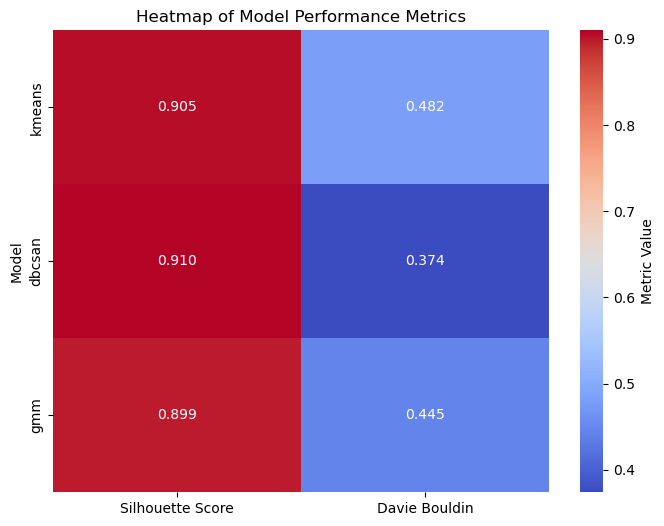

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Draw the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(eva, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Metric Value'})
plt.title("Heatmap of Model Performance Metrics")
plt.ylabel("Model")
plt.show()